In [1]:
import sys
sys.path.append("../")

In [2]:
import libs.AudioDataSet
import torchaudio.transforms as transforms
import torch
import matplotlib.pyplot as plt
import librosa
import hashlib
from scipy.ndimage.filters import maximum_filter, gaussian_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)

In [3]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1,figsize=(12,8))
    axs.set_title(None)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram),cmap="gray", origin="lower", aspect="auto")
    plt.show(block=False)
    axs.axes.get_xaxis().set_visible(False)
    axs.axes.get_yaxis().set_visible(False)
    axs.set_frame_on(False)
    axs.set_xlabel(None)
    axs.set_ylabel(None)
    fig.savefig('spectrogram.jpg')

In [4]:
dataSet = libs.AudioDataSet.AudioDataset("../data/compressed_index/")

In [5]:
audio = dataSet[0]

In [205]:
audio_slice = audio[:,-600000:-300000]

In [206]:
from moviepy.audio.AudioClip import AudioArrayClip
audio1 = AudioArrayClip(audio.T, fps=5512*2)
audio2 = AudioArrayClip(audio_slice.T, fps=5512*2)

audio2.write_audiofile('test_1.wav')
audio2.write_audiofile('test_2.wav')

MoviePy - Writing audio in test_2.wav


chunk:   0%|          | 0/151 [00:00<?, ?it/s, now=None]

MoviePy - Done.


In [8]:
def constellation_hash(peaks, neighbor_size=7):
    # peaks are fq x time
    peak_indices = torch.nonzero(peaks)
    
    for i in range(peak_indices.shape[0]):
        anchor = peak_indices[i]
        for j in range(1, min(neighbor_size, peak_indices.shape[0] - i)):
            # hash is: fq of anchor | fq of neighbor | neighbor.time - anchor.time
            neighbor = peak_indices[i+j]
            delta = neighbor[1] - anchor[1]
            if delta < 20:
                continue
            seq = f"{anchor[0]}|{neighbor[0]}|{delta}"
            h = hashlib.md5(seq.encode('utf-8'))
            # return (hash(seq), anchor.time)
            yield (h.hexdigest()[0:20], int(anchor[1]))

In [164]:
from datasketch import MinHash, MinHashLSH, MinHashLSHEnsemble, MinHashLSHForest

In [10]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
def minhash(peaks,name=""):
  minhashes = []
  nonzero = peaks.nonzero()
  
  # delta_time = nonzero[0][1]
  # m = MinHash(num_perm=128)
  # for peak in nonzero:
  #   if peak[1] - delta_time > 10:
  #     minhashes.append(m)
  #     lsh.insert(name+"_"+str(delta_time), m)
  #     m.clear()
  #     delta_time = peak[1]
  #   m.update(str(peak).encode('utf-8'))
  return minhashes

In [11]:
def get_peaks(samples):
  spec = transforms.Spectrogram(n_fft=1024, hop_length=256)(torch.from_numpy(samples))
  struct = generate_binary_structure(2, 1)
  neighborhood = iterate_structure(struct, 7)
  dilated = maximum_filter(spec[0],footprint=neighborhood, size=10)
  peaks = torch.abs(torch.from_numpy(dilated) - spec[0])
  peaks = torch.where(peaks == 0, 1, 0)
  background = binary_erosion(gaussian_filter(torch.abs(spec[0]), sigma=10), structure=neighborhood)
  erosed_peaks = peaks * background
  return erosed_peaks

In [12]:
def fingerprint(samples,name=""):
    spec = transforms.Spectrogram(n_fft=1024, hop_length=256)(torch.from_numpy(samples))
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 7)
    dilated = maximum_filter(spec[0],footprint=neighborhood, size=10)
    peaks = torch.abs(torch.from_numpy(dilated) - spec[0])
    peaks = torch.where(peaks == 0, 1, 0)
    background = binary_erosion(gaussian_filter(torch.abs(spec[0]), sigma=10), structure=neighborhood)
    erosed_peaks = peaks * background
    return minhash(erosed_peaks,name=name)
    # return  constellation_hash(erosed_peaks,neighbor_size=7)

In [13]:
from scipy import signal 
import numpy as np
def create_log_spectrogram(samples):
  S_scale = transforms.Spectrogram(n_fft=2048, hop_length=64)(torch.from_numpy(samples))
  Y_scale = torch.abs(S_scale)**2
  Y_log_scale = transforms.AmplitudeToDB(stype="power")(Y_scale)
  return Y_log_scale

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, ax = plt.subplots(5,4, figsize=(8, 2))
    print(ax)
    for i in range(5):
      for j in range(4):
        ax[i][j].axis("off")
        librosa.display.specshow(specgram[:,i*3*128+j*128:(j+1)*128+i*3*128],sr=5512,hop_length=64,cmap="gray", y_axis="log",bins_per_octave=32,x_axis="time",ax=ax[i][j])

In [14]:
def test(samples):
  C = np.abs(librosa.cqt(sr=5512, y=samples,fmin=20, hop_length=64, n_bins=32, bins_per_octave=32))
  return C

In [15]:
audio_slice.shape

(1, 400000)

In [16]:
#32 log-bins in 318-2000 Hz range
def filter(S_db,minFreq=318,maxFreq=2000):
  return S_db[:,minFreq:maxFreq,:]

In [17]:
specc1 = create_log_spectrogram(audio)
specc1= filter(specc1)


# plt.imshow(librosa.display.specshow(specc[0].numpy(),y_axis='log',x_axis='time'))

In [18]:
specc = create_log_spectrogram(audio_slice)
specc= filter(specc)


In [19]:
specc1 = test(audio)
specc = test(audio_slice)

In [158]:
import pywt

def getTopWavelet(img):
  coeffs2 = pywt.dwt2(img, 'haar')
  LL, (LH, HL, HH) = coeffs2
  # plt.imshow(img, cmap='gray'), plt.show()
  LL = np.where(LL >= np.sort(LL.flatten())[-200], 1, 0)
  LH = np.where(LH >= np.sort(LH.flatten())[-200], 1, 0)
  HL = np.where(HL >= np.sort(HL.flatten())[-200], 1, 0)
  HH = np.where(HH >= np.sort(HH.flatten())[-200], 1, 0)
  img = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
  img = np.where(img >= np.sort(img.flatten())[-200], 1, 0)
  # plt.imshow(img, cmap='gray'), plt.show()
  return img




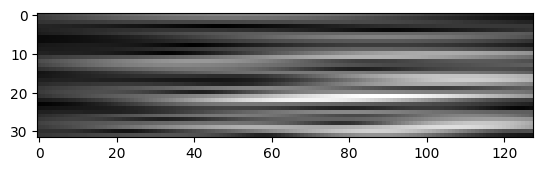

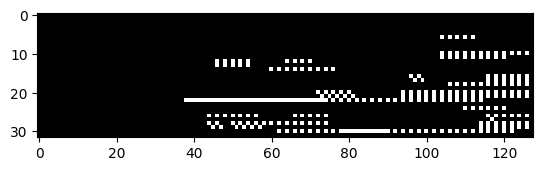

In [156]:
p = getTopWavelet(specc1[0,:,256:384])

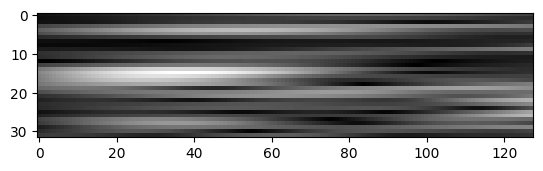

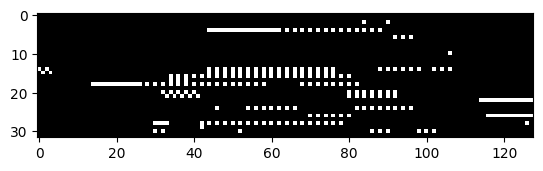

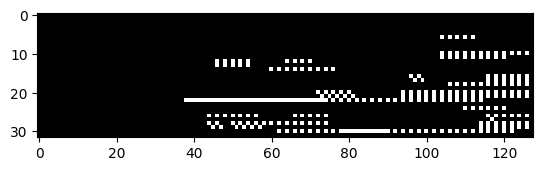

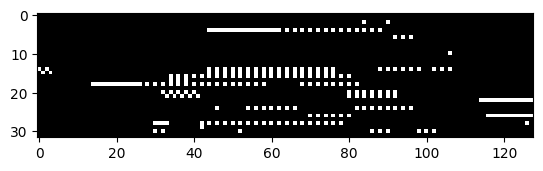

In [157]:

j = getTopWavelet(specc[0,:,0:128])
plt.imshow(p, cmap='gray')
plt.show()
plt.imshow(j, cmap='gray')
#1.48sec

In [207]:
fingerprints = []
for i in range(0,specc1.shape[2],128):
  fingerprints.append(getTopWavelet(specc1[0,:,i:i+128]).flatten())
len(fingerprints)

1101

In [160]:
m = MinHash(num_perm=25)


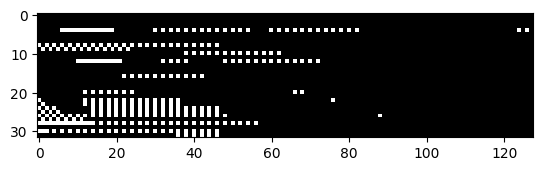

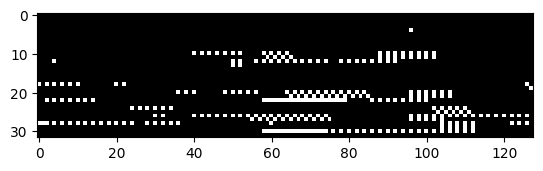

In [208]:
plt.imshow(fingerprints[0].reshape(32,128), cmap='gray')
plt.show()
plt.imshow(fingerprints[100].reshape(32,128), cmap='gray')

In [ ]:
fingerprints[0]

In [239]:
def minHASH(vector, num_perm):
  hash = []
  for _ in range(num_perm):
    hash.append(np.nonzero(np.random.permutation(vector))[0][0])
  return hash

In [381]:
def split_signature(signature, bands):
  assert len(signature) % bands == 0
  r = len(signature) // bands
  return [signature[i:i + r] for i in range(0, len(signature), r)]

In [382]:
def jaccard_index(p, q):
  intersect = sum(x and y for x, y in zip(p, q))
  union = sum(x or y for x, y in zip(p, q))
  if union == 0:
    print(0)
  else:
    print(intersect / union)

In [555]:
import numpy as np
import random
import struct
import hashlib
import numpy as np
 
def sha1_hash32(data):
    return struct.unpack('<I', hashlib.sha1(data).digest()[:4])[0]
_mersenne_prime = (1 << 61) - 1
_max_hash = (1 << 32) - 1
_hash_range = (1 << 32)
 
 
class MinHash(object):
 
    def __init__(self, d=128, seed=1,
            hashfunc=sha1_hash32,
            hashvalues=None, permutations=None):
        if hashvalues is not None:
            d = len(hashvalues)
        self.seed = seed
        # Check the hash function.
        if not callable(hashfunc):
            raise ValueError("The hashfunc must be a callable.")
        self.hashfunc = hashfunc
    
        # Initialize hash values
        if hashvalues is not None:
            self.hashvalues = self._parse_hashvalues(hashvalues)
        else:
            self.hashvalues = self._init_hashvalues(d)
        if permutations is not None:
            self.permutations = permutations
        else:
            generator = np.random.RandomState(self.seed)
            self.permutations = np.array([(generator.randint(1, _mersenne_prime, dtype=np.uint64),
                                           generator.randint(0, _mersenne_prime, dtype=np.uint64))
                                          for _ in range(d)], dtype=np.uint64).T
        if len(self) != len(self.permutations[0]):
            raise ValueError("Numbers of hash values and permutations mismatch")
 
    def _init_hashvalues(self, d):
        return np.ones(d, dtype=np.uint64)*_max_hash
 
    def _parse_hashvalues(self, hashvalues):
        return np.array(hashvalues, dtype=np.uint64)
 
    def add(self, b):
 
        hv = self.hashfunc(b)
        a, b = self.permutations
        phv = np.bitwise_and((a * hv + b) % _mersenne_prime, np.uint64(_max_hash))
        self.hashvalues = np.minimum(phv, self.hashvalues)
 
    def jaccard(self, other):
 
        if other.seed != self.seed:
            raise ValueError("different seeds")
        if len(self) != len(other):
            raise ValueError("different numbers of permutation functions")
        return np.float(np.count_nonzero(self.hashvalues==other.hashvalues)) /  np.float(len(self))
 
 
    def __len__(self):
        return len(self.hashvalues)
 
    def __eq__(self, other):
        return type(self) is type(other) and  self.seed == other.seed and np.array_equal(self.hashvalues, other.hashvalues)

def jaccard_sim(X, Y):
    """Jaccard similarity between two sets"""
    x = set(X)
    y = set(Y)
    return float(len(x & y)) / len(x | y)

def jaccard_similarity(signature1, signature2):
    """
    Compute the Jaccard similarity between two MinHash signatures.

    Parameters:
    signature1 (numpy array): MinHash signature of shape (num_hashes,)
    signature2 (numpy array): MinHash signature of shape (num_hashes,)

    Returns:
    similarity (float): Jaccard similarity between the two signatures
    """
    intersection = np.sum(np.bitwise_and(signature1, signature2))
    union = np.sum(np.bitwise_or(signature1, signature2))
    return intersection / union

# Example usage
arr1 = np.array([1,0,1,0,0,0,1,0,0,0,0,0])
arr2 = np.array([1,0,1,0,0,0,0,0,0,0,0,0])

mh1= MinHash(d = 100)

mh1.add(arr1)
mh1.add(arr2)

# print(mh1.jaccard(mh2),"JACCARD")

num_hashes = 100
print(mh1.hashvalues)
print(mh1.hashvalues)
real_sim = jaccard_similarity(arr1, arr2)
similarity = jaccard_sim(mh1.hashvalues, mh1.hashvalues)
print("Real Jaccard similarity:", real_sim)
print("Jaccard similarity:", similarity)

[ 908200344  945407971  604385290 1453191169  680204437 3206833751
 1202610759 2210311824  175793395   99617645 1058409669 1358226363
 2974362145 1606718776  665196626  409959366 3833717061 1662789359
 1643623817 2901882861  617270310 1113890501 2424233216 1048068197
 2207788833 2592917544 3125596919  802818135 2301792615 2132658913
 2256590659  429522367  482104716 1382114952 2913526407   48848591
 1956094129  857824563 1456585091 3797617870  918797642 2153646847
 1187604780 2074683266  255557506 1843528683 3107777324 1249988504
 1131834212 2770129635 1207294557 1085175536 3008767119  517764787
 2704088294 1068947308 1253169399 3827601407 1236885501 2058389881
  877952699 1813692321  110672468  606943717  543697901 2993441683
  908276619 1650521313 1031401012  575287871 1684177182  228267681
   98998538 1339133197 1962188182 1235443866 1056763356  914172923
 2900737751  626949106  626487806  474020489  613686995 1065924491
 1447171166 2768067331 4012259789 1780732159  109601100 242554

In [550]:

p = [1,0,1,0,0,0,1,0,0,0,0,0]
q = [1,0,1,0,0,0,1,0,0,0,0,0]

min_hash_p = minHASH(p, 100)
min_hash_q = minHASH(q, 100)

m_p = MinHash(num_perm=100)
m_q = MinHash(num_perm=100)

for i in p:
  m_p.update(str(i).encode('utf-8'))

for i in q:
  m_q.update(str(i).encode('utf-8'))
jaccard_index(min_hash_p, min_hash_q)
print(m_p.jaccard(m_q))
  


bands_p = split_signature(min_hash_p, 25)
bands_q = split_signature(min_hash_q, 25)

TypeError: MinHash.__init__() got an unexpected keyword argument 'num_perm'

In [401]:
np.nonzero(np.random.permutation(fingerprints[0]))[0][0]

12

In [380]:
mh_a = MinHash(num_perm=100)
mh_b = MinHash(num_perm=100)

    
jaccard_index(p, q)
jaccard_index(minHASH(p, 400), minHASH(q, 400))

for i in fingerprints[0]:
  mh_a.update(i)

for i in fingerprints[1000]:
  mh_b.update(i)
  
sum(mh_a.digest()), sum(mh_b.digest()),fingerprints[0].sum(), fingerprints[1000].sum()

0.6666666666666666
0.8717077315208156


(138125984943.0, 138125984943.0, 307, 344)

In [244]:
lsh = MinHashLSHForest(num_perm=100)
minhashes = {}
for c,f in enumerate(fingerprints):
  m = MinHash(num_perm=100)
  zero = np.where(f == 0)[0]
  one = np.where(f == 1)[0]
  for i in zero:
    m.update(str(i).encode('utf-8'))
  for i in one:
    m.update(str(i).encode('utf-8'))
  lsh.add(c, m)
  minhashes[c] = m
lsh.index()

In [210]:
fingerprints2 = []
for i in range(0,specc.shape[2],128):
  fingerprints2.append(getTopWavelet(specc[0,:,i:i+128]).flatten())
minhashes2 = {}
for c,f in enumerate(fingerprints2):
  m = MinHash(num_perm=100)
  zero = np.where(f == 0)[0]
  one = np.where(f == 1)[0]
  for i in zero:
    m.update(str(i).encode('utf-8'))
  for i in one:
    m.update(str(i).encode('utf-8'))
  # lsh.insert(c, m)
  minhashes2[c] = m



In [211]:
result = lsh.query(minhashes2[0],10)
print(result)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [214]:
count = 0
for key, value in minhashes2.items():
  query = lsh.query(value,3)
  if len(query) > 0 :
    print(key,query)
    

0 [0, 1, 2]
1 [0, 1, 2]
2 [0, 1, 2]
3 [0, 1, 2]
4 [0, 1, 2]
5 [0, 1, 2]
6 [0, 1, 2]
7 [0, 1, 2]
8 [0, 1, 2]
9 [0, 1, 2]
10 [0, 1, 2]
11 [0, 1, 2]
12 [0, 1, 2]
13 [0, 1, 2]
14 [0, 1, 2]
15 [0, 1, 2]
16 [0, 1, 2]
17 [0, 1, 2]
18 [0, 1, 2]
19 [0, 1, 2]
20 [0, 1, 2]
21 [0, 1, 2]
22 [0, 1, 2]
23 [0, 1, 2]
24 [0, 1, 2]
25 [0, 1, 2]
26 [0, 1, 2]
27 [0, 1, 2]
28 [0, 1, 2]
29 [0, 1, 2]
30 [0, 1, 2]
31 [0, 1, 2]
32 [0, 1, 2]
33 [0, 1, 2]
34 [0, 1, 2]
35 [0, 1, 2]
36 [0, 1, 2]
37 [0, 1, 2]
38 [0, 1, 2]
39 [0, 1, 2]
40 [0, 1, 2]
41 [0, 1, 2]
42 [0, 1, 2]
43 [0, 1, 2]
44 [0, 1, 2]
45 [0, 1, 2]
46 [0, 1, 2]
47 [0, 1, 2]
48 [0, 1, 1100]


In [213]:
for k,m in minhashes2.items():
  for k2,n in minhashes.items():
    if m.jaccard(n) > 0.53 and m.jaccard(n) < 0.83:
      print(k,k2,m.jaccard(n))

In [ ]:
specc1.shape

(1, 32, 140901)

In [ ]:
fin = specc.unfold(0,128,64)

AttributeError: 'numpy.ndarray' object has no attribute 'unfold'

In [ ]:
fin.shape

torch.Size([10, 10157, 128])

In [ ]:
full = fingerprint(audio,"full")
slice = fingerprint(audio_slice,"slice")

In [ ]:
keys = lsh.hashtables

In [ ]:
slice_peaks = get_peaks(audio_slice)
audio_peaks = get_peaks(audio)

In [ ]:
slice_peaks.shape

torch.Size([513, 2540])

In [ ]:

def get_minhashes(peaks,sr=1024,hop=256):
  step = sr//hop
  non_zero_secs = []
  for a in range(0,peaks.shape[1],step):
    non_zero_secs.append(peaks[:,a:a+step].nonzero())
  minhashes = []
  for sec,fq_time in enumerate(non_zero_secs):
    m = MinHash(num_perm=64)
    for pq in fq_time:
      m.update(str(pq).encode('utf-8'))
    minhashes.append(m)
    m.clear()
  return minhashes



In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=64)
full_M = get_minhashes(audio_peaks)
for sec,m in enumerate(full_M):
  if m.count()>0:
    lsh.insert(f"full_{sec}", m)

In [ ]:



set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

target = MinHash(num_perm=128)
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for d in set1:
    target.update(d.encode('utf8'))
m = MinHash(num_perm=128)
for d in set2:
    m.update(d.encode('utf8'))
lsh.insert("m2", m)
m.clear()
for d in set3:
    m.update(d.encode('utf8'))
lsh.insert("m3", m)
result = lsh.query(target)
print("Approximate neighbours with Jaccard similarity > 0.5", result)

Approximate neighbours with Jaccard similarity > 0.5 ['m2', 'm3']


dict_keys([b'\x00\x00\x00\x00\xb7^\x1a\x99\x00\x00\x00\x00L>\xbf_\x00\x00\x00\x00i\x82\x08\xce\x00\x00\x00\x00\xe4S^\x85\x00\x00\x00\x00`\xba$\x05', b'\x00\x00\x00\x00\'\xa6\xbf\xfb\x00\x00\x00\x00\xf7\x85\xd8\xb3\x00\x00\x00\x00#h\xfd\x85\x00\x00\x00\x00\xf2\xefc\x1e\x00\x00\x00\x00\x80"U~', b'\x00\x00\x00\x00\xfe\xec\xdc\xe1\x00\x00\x00\x00o\x8c\xb6@\x00\x00\x00\x00L\x90\xa5\xe4\x00\x00\x00\x00\xcf\x07\xec\xb8\x00\x00\x00\x00\x0f\x80u=', b'\x00\x00\x00\x00%\x05&\xeb\x00\x00\x00\x00\xe6\x86u5\x00\x00\x00\x00\x9f0\xbd\xfb\x00\x00\x00\x00\xc7&\xc3\xbc\x00\x00\x00\x00\xc3\x1bWE', b'\x00\x00\x00\x00\x94\x18\xc5\xc2\x00\x00\x00\x00\x8f\x17a\xcb\x00\x00\x00\x00\xa3\x92\xbf\t\x00\x00\x00\x00\xfb\xd5\x7f\xf4\x00\x00\x00\x00\xb2`\xcfK', b'\x00\x00\x00\x00q\xfdb)\x00\x00\x00\x00\x8f\x00\x17\x99\x00\x00\x00\x00P\xaf1j\x00\x00\x00\x00\xdd\x06;@\x00\x00\x00\x00\xbd\xfd\x98\xa4', b'\x00\x00\x00\x00\xea\xf2\xb2f\x00\x00\x00\x00\xf7\x9c\xe3y\x00\x00\x00\x00#\xfe\xf8f\x00\x00\x00\x00\x08\x16\x82g\x00\

In [ ]:
full_map = dict(full)
slice_map = dict(slice)
st = set(full_map.keys()).intersection(set(slice_map.keys()))

TypeError: 'MinHash' object is not iterable

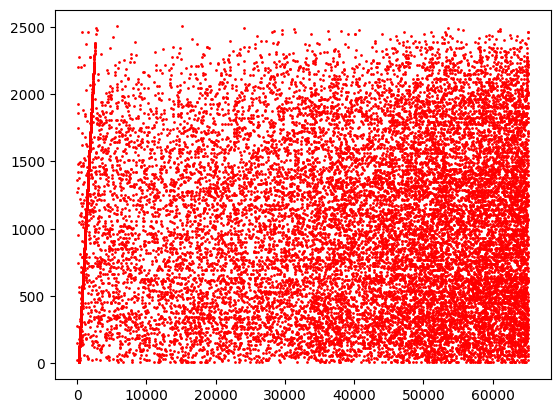

In [ ]:
array_full = []
array_slice = []
for key in st:
  array_full.append(full_map[key])
  array_slice.append(slice_map[key])
plt.scatter(array_full, array_slice,s=1, color='red')
plt.show()